In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import datashader as ds
from datashader.colors import Elevation
from datashader.transfer_functions import shade, stack, dynspread, set_background

## Load Shapefile

In [2]:
df_geom = gpd.read_file("../dataset/shp/america/sea_grid_count_americas.shp")
df_geom = df_geom[["NUMPOINTS", "geometry"]]
df_geom["ZONE_ID"] = range(1, len(df_geom) + 1)
df_geom.head()

,NUMPOINTS,geometry,ZONE_ID
0,0.0,"POLYGON ((43.68476 -12.35978, 43.68476 -12.323...",1
1,0.0,"POLYGON ((30.40476 -3.66758, 30.40476 -3.19368...",2
2,0.0,"POLYGON ((37.04476 -2.69547, 37.04476 -2.36368...",3
3,0.0,"POLYGON ((20.44476 -34.73368, 20.08328 -34.733...",4
4,0.0,"POLYGON ((20.44476 -34.73368, 20.44476 -35.563...",5


In [3]:
df_geom.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1141 entries, 0 to 1140
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   NUMPOINTS  1141 non-null   float64 
 1   geometry   1141 non-null   geometry
 2   ZONE_ID    1141 non-null   int64   
dtypes: float64(1), geometry(1), int64(1)
memory usage: 26.9 KB


<Axes: >

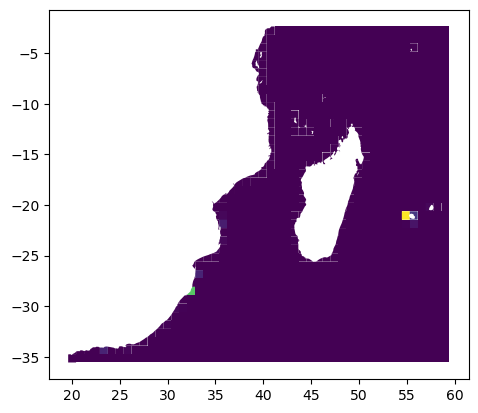

In [4]:
df_geom.plot(column="NUMPOINTS")

## Occurence + Zone

In [11]:
df_occ = pd.read_csv("../dataset/darwin_humpback_whale/occurence_proc.csv", parse_dates=["ts"])
df_occ["ts_date"] = df_occ["ts"].dt.strftime("%Y-%m-%d")
df_occ["ts_mm"] = df_occ["ts"].dt.strftime("%Y-%m")
df_occ.head()

,ts,latitude,longitude,species,ts_date,ts_mm
0,2023-11-30 09:44:11,-25.363597,46.837436,Megaptera novaeangliae,2023-11-30,2023-11
1,2023-11-21 00:00:00,-21.220602,55.205602,Megaptera novaeangliae,2023-11-21,2023-11
2,2023-11-19 16:19:50,-33.476485,115.064949,Megaptera novaeangliae,2023-11-19,2023-11
3,2023-11-14 00:00:00,-21.235409,55.226194,Megaptera novaeangliae,2023-11-14,2023-11
4,2023-11-13 00:00:00,-21.269454,55.201475,Megaptera novaeangliae,2023-11-13,2023-11


In [12]:
df_occ_points = gpd.GeoDataFrame(df_occ, geometry=gpd.points_from_xy(df_occ["longitude"], df_occ["latitude"]), crs="EPSG:4326")
df_occ_points.head()

,ts,latitude,longitude,species,ts_date,ts_mm,geometry
0,2023-11-30 09:44:11,-25.363597,46.837436,Megaptera novaeangliae,2023-11-30,2023-11,POINT (46.83744 -25.36360)
1,2023-11-21 00:00:00,-21.220602,55.205602,Megaptera novaeangliae,2023-11-21,2023-11,POINT (55.20560 -21.22060)
2,2023-11-19 16:19:50,-33.476485,115.064949,Megaptera novaeangliae,2023-11-19,2023-11,POINT (115.06495 -33.47648)
3,2023-11-14 00:00:00,-21.235409,55.226194,Megaptera novaeangliae,2023-11-14,2023-11,POINT (55.22619 -21.23541)
4,2023-11-13 00:00:00,-21.269454,55.201475,Megaptera novaeangliae,2023-11-13,2023-11,POINT (55.20148 -21.26945)


In [13]:
df_occ_points[df_occ_points["ts_date"] == "2023-11-30"]

,ts,latitude,longitude,species,ts_date,ts_mm,geometry
0,2023-11-30 09:44:11,-25.363597,46.837436,Megaptera novaeangliae,2023-11-30,2023-11,POINT (46.83744 -25.36360)


In [14]:
df_occ_points.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10502 entries, 0 to 10501
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ts         10502 non-null  datetime64[ns]
 1   latitude   10502 non-null  float64       
 2   longitude  10502 non-null  float64       
 3   species    10502 non-null  object        
 4   ts_date    10502 non-null  object        
 5   ts_mm      10502 non-null  object        
 6   geometry   10502 non-null  geometry      
dtypes: datetime64[ns](1), float64(2), geometry(1), object(3)
memory usage: 574.5+ KB


In [15]:
df_occ.groupby("ts_mm").count()

,ts,latitude,longitude,species,ts_date
ts_mm,,,,,
1988-07,3,3,3,3,3
1989-07,3,3,3,3,3
1990-07,3,3,3,3,3
1990-08,67,67,67,67,67
1990-09,44,44,44,44,44
...,...,...,...,...,...
2023-07,556,556,556,556,556
2023-08,418,418,418,418,418
2023-09,137,137,137,137,137


<Axes: xlabel='ts_mm'>

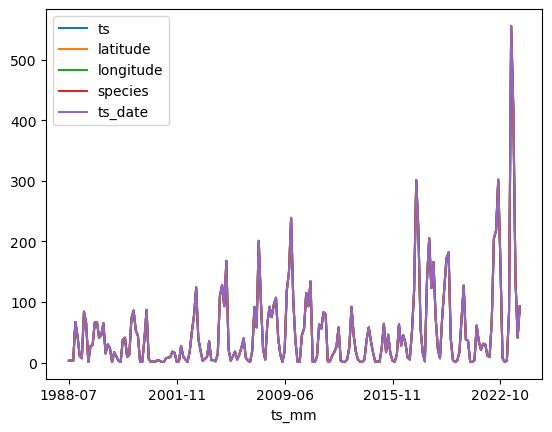

In [16]:
df_occ.groupby("ts_mm").count().plot.line()

## Points

In [17]:
dfin = gpd.sjoin(df_geom, df_occ_points, how="left")
dfin

,NUMPOINTS,geometry,ZONE_ID,index_right,ts,latitude,longitude,species,ts_date,ts_mm
0,0.0,"POLYGON ((43.68476 -12.35978, 43.68476 -12.323...",1,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,0.0,"POLYGON ((30.40476 -3.66758, 30.40476 -3.19368...",2,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,0.0,"POLYGON ((37.04476 -2.69547, 37.04476 -2.36368...",3,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,0.0,"POLYGON ((20.44476 -34.73368, 20.08328 -34.733...",4,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,0.0,"POLYGON ((20.44476 -34.73368, 20.44476 -35.563...",5,NaN,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1136,0.0,"POLYGON ((58.62476 -31.41368, 59.45476 -31.413...",1137,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1137,0.0,"POLYGON ((58.62476 -32.24368, 59.45476 -32.243...",1138,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1138,0.0,"POLYGON ((58.62476 -33.07368, 59.45476 -33.073...",1139,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1139,0.0,"POLYGON ((58.62476 -33.90368, 59.45476 -33.903...",1140,NaN,NaT,NaN,NaN,NaN,NaN,NaN


In [21]:
dfin.groupby("ZONE_ID").count().reset_index().sort_values("geometry")

,ZONE_ID,NUMPOINTS,geometry,index_right,ts,latitude,longitude,species,ts_date,ts_mm
0,1,1,1,0,0,0,0,0,0,0
748,749,1,1,0,0,0,0,0,0,0
749,750,1,1,0,0,0,0,0,0,0
750,751,1,1,0,0,0,0,0,0,0
751,752,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
11,12,250,250,250,250,250,250,250,250,250
74,75,261,261,261,261,261,261,261,261,261
963,964,422,422,422,422,422,422,422,422,422
63,64,1924,1924,1924,1924,1924,1924,1924,1924,1924
